# $\fbox{1-4}$  死亡率推定方法の妥当性確認

## 死亡率計算の準備と検討

In [1]:
# グラフを移動拡大縮小したい場合
%matplotlib notebook
# グラフをインラインで表示
# %matplotlib inline

import gc

import mylibs.mylib1 as mylib1  # 本書 1 章の関数群を含む自作ライブラリ
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm

# 表示する行・列の数を設定
pd.options.display.max_rows = 6
pd.options.display.max_columns = 14

# matplotlib のフォントを設定
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'stix'

In [2]:
df_info = pd.read_csv('./pseudo_medical/records/excl_bp/info.csv')

df_info

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,death
0,i000000,M,1,1952/06,2010/01,2013/09,0
1,i000001,F,2,1972/11,2010/01,2019/12,0
2,i000002,M,1,1978/03,2010/01,2016/09,0
...,...,...,...,...,...,...,...
4812,i008260,M,1,1987/02,2019/06,2019/12,0
4813,i008263,M,1,1980/08,2010/01,2016/11,0
4814,i008264,M,2,1952/06,2010/01,2010/10,0


In [3]:
death = df_info['death'].sum()

death

34

In [4]:
exposure = (df_info.end_obs_ym.apply(mylib1.ym_to_t)
            - df_info.start_obs_ym.apply(mylib1.ym_to_t)
            ).sum()

exposure

25048.333333332965

In [5]:
# 平均観察死亡率
q = death / exposure

q

0.0013573757402355645

## 死亡率を $100$ 倍して加入者データを再作成

In [6]:
# 引数設定
df_birth = pd.read_csv('./public_stats/processed/ipss_birth.csv')
start_study_t = 2010    # 分析開始時点 (2010年1月)
end_study_t = 2019.999  # 分析終了時点 (2019年12月)
mu = 10
N = 10000            # N 人の加入者を生成する。
family_ratio = 0.3   # 全体の内、被扶養者の占める割合
df_mortality = pd.read_csv('./public_stats/processed/ipss_mortality.csv')

df_mortality  # 100 倍する前の元の月次死亡率

,alb,F,M
0,0,0.000098,0.000097
1,1,0.000020,0.000022
2,2,0.000011,0.000013
...,...,...,...
97,97,0.023992,0.034089
98,98,0.027662,0.038338
99,99,0.031471,0.043682


<IPython.core.display.Javascript object>


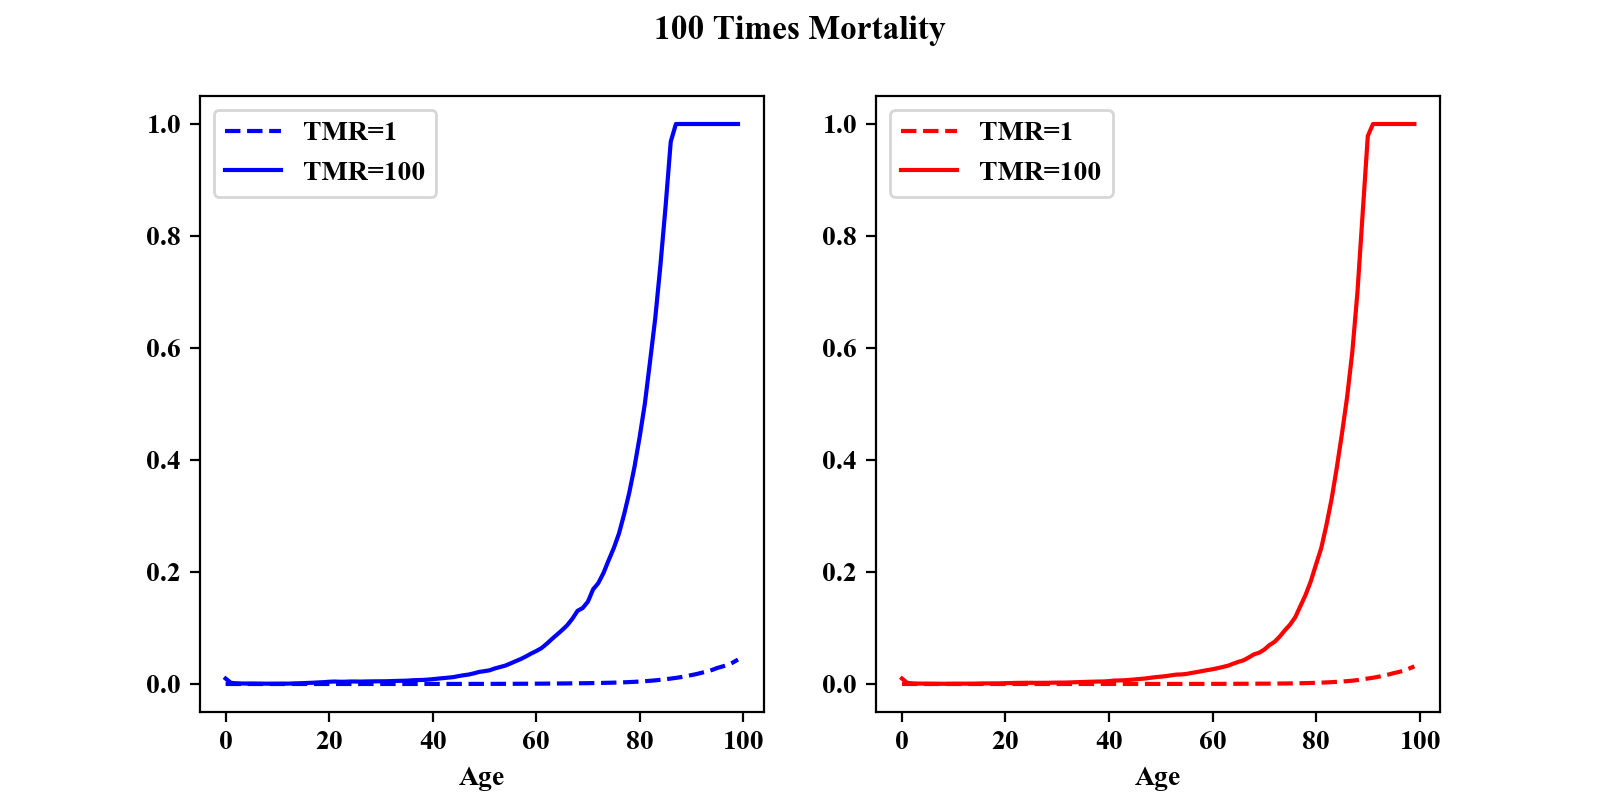

Text(0.5, 0.98, '100 Times Mortality')

In [7]:
# 100 倍死亡率のキャップ計算と概念図

fig = plt.figure(figsize=(8, 4))

# 男性
ax_M = fig.add_subplot(121)
ax_M.plot(df_mortality.alb, df_mortality.M, c='b', ls='--', label='TMR=1')
df_mortality['M'] = df_mortality.M * 100
df_mortality.loc[(df_mortality.M > 1), 'M'] = 1
ax_M.plot(df_mortality.alb, df_mortality.M, c='b', ls='-', label='TMR=100')
ax_M.legend()
ax_M.set_xlabel('Age')

# 女性
ax_F = fig.add_subplot(122)
ax_F.plot(df_mortality.alb, df_mortality.F, c='r', ls='--', label='TMR=1')
df_mortality['F'] = df_mortality.F * 100
df_mortality.loc[(df_mortality.F > 1), 'F'] = 1
ax_F.plot(df_mortality.alb, df_mortality.F, c='r', ls='-', label='TMR=100')
ax_F.legend()
ax_F.set_xlabel('Age')

fig.suptitle('100 Times Mortality')

In [8]:
df_mortality

,alb,F,M
0,0,0.009759,0.009734
1,1,0.002029,0.002159
2,2,0.001133,0.001296
...,...,...,...
97,97,1.000000,1.000000
98,98,1.000000,1.000000
99,99,1.000000,1.000000


In [9]:
# df_info の作成
df_info = mylib1.create_df_info(df_birth, df_mortality,
                                start_study_t, end_study_t,
                                mu, N, family_ratio)

df_info

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,death
0,i000000,M,1,1952/06,2010/01,2011/05,1
1,i000001,F,2,1972/11,2010/01,2019/12,0
2,i000002,M,1,1978/03,2010/01,2016/09,0
...,...,...,...,...,...,...,...
9997,i016632,M,1,2001/07,2010/01,2014/05,0
9998,i016633,M,2,1969/03,2010/01,2013/11,0
9999,i016634,F,1,1986/09,2010/01,2018/07,0


In [10]:
death = df_info.death.sum()

death

3683

In [11]:
# 年次エクスポージャ [人年]
exposure = (df_info.end_obs_ym.apply(mylib1.ym_to_t)
            - df_info.start_obs_ym.apply(mylib1.ym_to_t)
            ).sum()

exposure

36691.416666666046

In [12]:
# 平均月次死亡率
q = death / exposure

q

0.10037769959822744

## 男女別・年齢別観察死亡率の推定

### 年月（文字列）の数値化

In [13]:
col_ts = ['start_obs_t',  'end_obs_t',  'birth_t']
col_yms = ['start_obs_ym', 'end_obs_ym', 'birth_ym']
for (col_t, col_ym) in zip(col_ts, col_yms):
    df_info[col_t] = df_info[col_ym].apply(mylib1.ym_to_t)

### ALB テーブルの作成

In [14]:
# npa_obs_ym は観察年月の配列
npa_obs_ym = mylib1.create_npa_obs_ym(start_study_t, end_study_t)

df_alb_table = df_info.copy()

npa_birth_t = np.array(df_info['birth_t'])
for ym in npa_obs_ym:
    t = mylib1.ym_to_t(ym)
    df_alb_table[ym] = (t - npa_birth_t) // 1
    df_alb_table[ym] = df_alb_table[ym].astype('int8')

df_alb_table

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,death,...,2019/06,2019/07,2019/08,2019/09,2019/10,2019/11,2019/12
0,i000000,M,1,1952/06,2010/01,2011/05,1,...,67,67,67,67,67,67,67
1,i000001,F,2,1972/11,2010/01,2019/12,0,...,46,46,46,46,46,47,47
2,i000002,M,1,1978/03,2010/01,2016/09,0,...,41,41,41,41,41,41,41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,i016632,M,1,2001/07,2010/01,2014/05,0,...,17,18,18,18,18,18,18
9998,i016633,M,2,1969/03,2010/01,2013/11,0,...,50,50,50,50,50,50,50
9999,i016634,F,1,1986/09,2010/01,2018/07,0,...,32,32,32,33,33,33,33


### 月次エクスポージャテーブルの作成

In [15]:
df_exposure_table = df_alb_table.copy()
for ym in npa_obs_ym:
    # Boolean values for Start_obs_t
    bs = (df_exposure_table['start_obs_t'] <= mylib1.ym_to_t(ym))
    # Boolean values for End_obs_t
    be = (mylib1.ym_to_t(ym) <= df_exposure_table['end_obs_t'])
    df_exposure_table[ym] = (bs & be) * 1

df_exposure_table

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,death,...,2019/06,2019/07,2019/08,2019/09,2019/10,2019/11,2019/12
0,i000000,M,1,1952/06,2010/01,2011/05,1,...,0,0,0,0,0,0,0
1,i000001,F,2,1972/11,2010/01,2019/12,0,...,1,1,1,1,1,1,1
2,i000002,M,1,1978/03,2010/01,2016/09,0,...,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,i016632,M,1,2001/07,2010/01,2014/05,0,...,0,0,0,0,0,0,0
9998,i016633,M,2,1969/03,2010/01,2013/11,0,...,0,0,0,0,0,0,0
9999,i016634,F,1,1986/09,2010/01,2018/07,0,...,0,0,0,0,0,0,0


### 月次死亡テーブルの作成

In [16]:
event = 'death'
N = len(df_alb_table)
df_event_table = df_alb_table.copy()

df_event_table[npa_obs_ym] = np.zeros((N, len(npa_obs_ym)))
i_of_events = df_event_table[df_event_table[event] == 1].index
for i in i_of_events:
    event_ym = df_event_table.loc[i, 'end_obs_ym']
    df_event_table.loc[i, event_ym] = 1

df_event_table

,iid,sex,family,birth_ym,start_obs_ym,end_obs_ym,death,...,2019/06,2019/07,2019/08,2019/09,2019/10,2019/11,2019/12
0,i000000,M,1,1952/06,2010/01,2011/05,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,i000001,F,2,1972/11,2010/01,2019/12,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,i000002,M,1,1978/03,2010/01,2016/09,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9997,i016632,M,1,2001/07,2010/01,2014/05,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,i016633,M,2,1969/03,2010/01,2013/11,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9999,i016634,F,1,1986/09,2010/01,2018/07,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### ALB ごとにエクスポージャと死亡数を集計

In [17]:
cols = ['sex', 'alb', 'exposure', event]
df_summary = pd.DataFrame(np.zeros((200, 4)), columns=cols)
df_summary['sex'] = np.concatenate([np.repeat('M', 100), np.repeat('F', 100)])
df_summary['alb'] = np.concatenate([np.arange(100), np.arange(100)])
types = {'alb': 'int8', 'exposure': 'int32', event: 'int8'}
df_summary = df_summary.astype(types)

df_summary

,sex,alb,exposure,death
0,M,0,0,0
1,M,1,0,0
2,M,2,0,0
...,...,...,...,...
197,F,97,0,0
198,F,98,0,0
199,F,99,0,0


In [18]:
for sex in ['M', 'F']:
    for alb in np.arange(100):
        # print(sex, alb)
        sex_filter = (df_alb_table['sex'] == sex).values.reshape(N, 1) * 1
        alb_filter = (df_alb_table[npa_obs_ym] == alb).values * 1
        i_smry = (sex == 'F') * 100 + alb
        df_summary.loc[i_smry, 'exposure'] = (
                df_exposure_table[npa_obs_ym].values
                * sex_filter * alb_filter
                ).sum().sum()
        df_summary.loc[i_smry, event] = (df_event_table[npa_obs_ym].values
                                           * sex_filter
                                           * alb_filter).sum().sum()

df_summary

,sex,alb,exposure,death
0,M,0,2633,4.0
1,M,1,3064,11.0
2,M,2,3423,8.0
...,...,...,...,...
197,F,97,0,0.0
198,F,98,0,0.0
199,F,99,0,0.0


In [19]:
df_summary[event].sum()

3683.0

In [20]:
e = 0.05
df_summary['obs_rate'] = df_summary[event] / df_summary['exposure']
df_summary['LCL'] = mylib1.calc_LCL(df_summary['exposure'],
                                    df_summary[event], e)
df_summary['UCL'] = mylib1.calc_UCL(df_summary['exposure'],
                                    df_summary[event], e)

df_summary.iloc[:60]

,sex,alb,exposure,death,obs_rate,LCL,UCL
0,M,0,2633,4.0,0.001519,0.000591,0.003900
1,M,1,3064,11.0,0.003590,0.002006,0.006417
2,M,2,3423,8.0,0.002337,0.001185,0.004605
...,...,...,...,...,...,...,...
57,M,57,1852,75.0,0.040497,0.032429,0.050467
58,M,58,1777,85.0,0.047833,0.038849,0.058769
59,M,59,1584,93.0,0.058712,0.048168,0.071392


In [21]:
df_summary['true_rate'] = np.zeros(len(df_summary))
for sex in ['M', 'F']:
    for alb in np.arange(100):
        i_smry = (sex == 'F') * 100 + alb
        df_summary.loc[i_smry, 'true_rate'] \
            = mylib1.get_mortality(df_mortality, sex, alb)

df_summary.iloc[:60]

,sex,alb,exposure,death,obs_rate,LCL,UCL,true_rate
0,M,0,2633,4.0,0.001519,0.000591,0.003900,0.009734
1,M,1,3064,11.0,0.003590,0.002006,0.006417,0.002159
2,M,2,3423,8.0,0.002337,0.001185,0.004605,0.001296
...,...,...,...,...,...,...,...,...
57,M,57,1852,75.0,0.040497,0.032429,0.050467,0.044475
58,M,58,1777,85.0,0.047833,0.038849,0.058769,0.049124
59,M,59,1584,93.0,0.058712,0.048168,0.071392,0.054270


### 観察死亡率と真の死亡率の可視化による比較

<IPython.core.display.Javascript object>


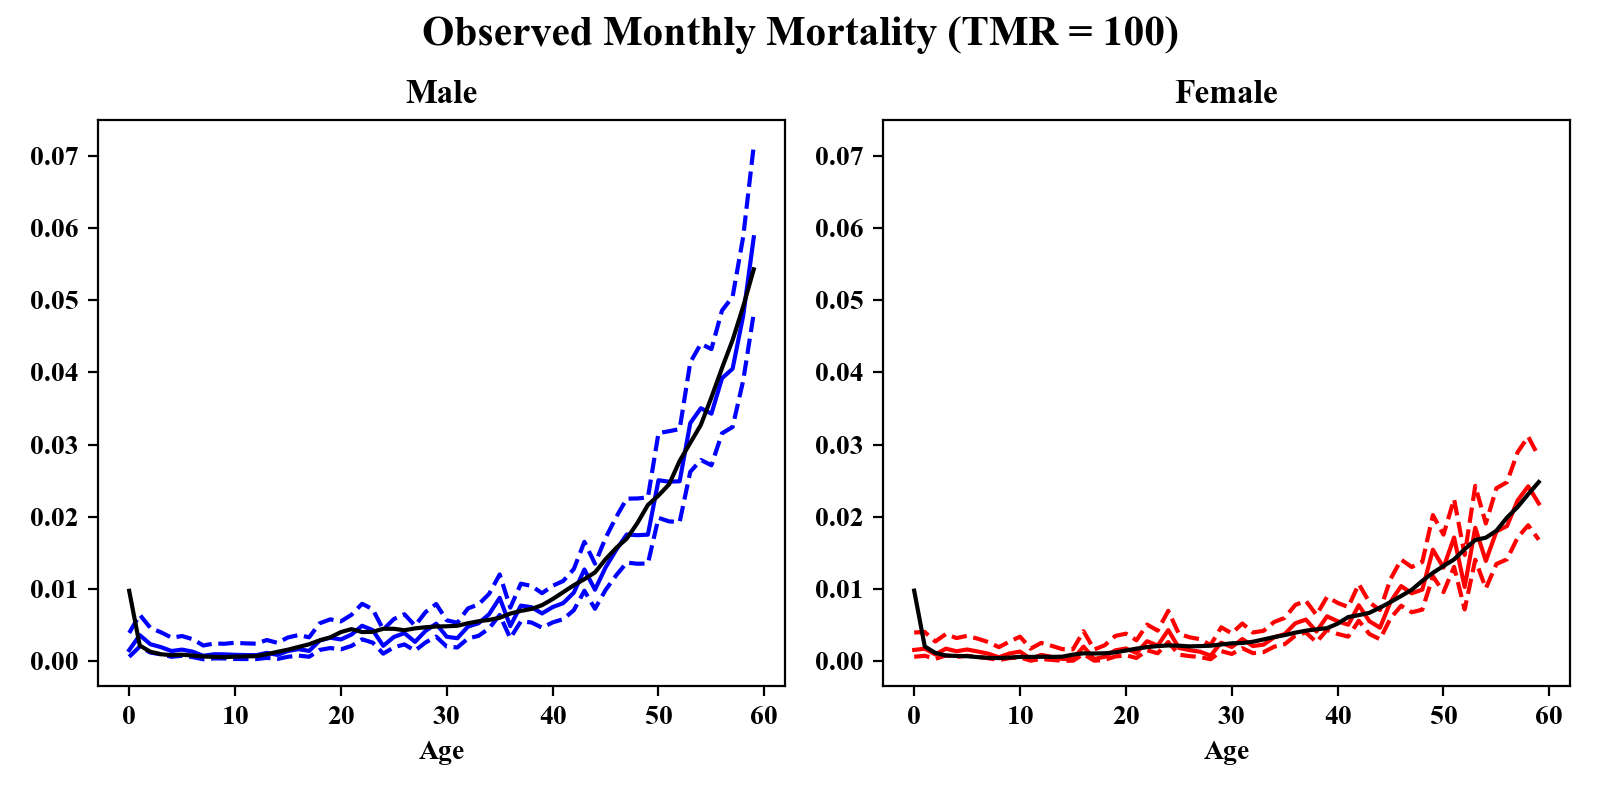

In [22]:
# %matplotlib notebook

df_summary_M = df_summary[df_summary['sex'] == 'M']
df_summary_F = df_summary[df_summary['sex'] == 'F']
fig = plt.figure(figsize=(8, 4))
fig.suptitle('Observed Monthly Mortality (TMR = 100)', fontsize=15)

ax1 = fig.add_subplot(121)
ax1.plot(df_summary_M['alb'][:60], df_summary_M['obs_rate'][:60], '-', c='b')
ax1.plot(df_summary_M['alb'][:60], df_summary_M['LCL'][:60], '--', c='b')
ax1.plot(df_summary_M['alb'][:60], df_summary_M['UCL'][:60], '--', c='b')
ax1.plot(df_summary_M['alb'][:60], df_summary_M['true_rate'][:60], '-', c='k')
ax1.set_title('Male')
ax1.set_xlabel('Age')

ax2 = fig.add_subplot(122, sharey=ax1)
ax2.plot(df_summary_F['alb'][:60], df_summary_F['obs_rate'][:60], '-', c='r')
ax2.plot(df_summary_F['alb'][:60], df_summary_F['LCL'][:60], '--', c='r')
ax2.plot(df_summary_F['alb'][:60], df_summary_F['UCL'][:60], '--', c='r')
ax2.plot(df_summary_F['alb'][:60], df_summary_F['true_rate'][:60], '-', c='k')
ax2.set_title('Female')
ax2.set_xlabel('Age')

plt.tight_layout()
plt.subplots_adjust(top=0.85)

### 一連のプログラムを関数化

In [23]:
mylib1.convert_ym_to_t_in_info??

## まとめ